In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import logging
import os
import pickle
from pathlib import Path
from time import perf_counter

import numpy as np

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.misc import get_atoms_batch
from mcmc.utils.plot import plot_summary_stats

np.set_printoptions(precision=3, suppress=True)

Initialize pristine slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3_001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/SrTiO3_001/SrTiO3_001_2x2_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e
offset_data_path = os.path.join(
    os.getcwd(),
    "data/SrTiO3_001/nff",
    "offset_data.json",
)

try:
    with open(offset_data_path, "r") as f:
        offset_data = json.load(f)
except FileNotFoundError as e:
    print("Offset data file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": offset_data,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

In [4]:
# this is giving a segmentation fault
from nff.io.ase_calcs import NeuralFF

: 

Set up NFF Calculator. Here, we are using the same neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file.

In [ ]:
import torch
from nff.utils.cuda import cuda_devices_sorted_by_free_mem

from mcmc.calculators import EnsembleNFFSurface

DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}" if torch.cuda.is_available() else "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/SrTiO3_001/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models


16:07:06 - mcmc.calculators | INFO: chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
16:07:06 - mcmc.calculators | INFO: offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


{'calc_name': 'NFF',
 'optimizer': 'BFGS',
 'chem_pots': {'Sr': -2, 'Ti': 0, 'O': 0},
 'relax_atoms': True,
 'relax_steps': 20,
 'offset': True,
 'offset_data': {'bulk_energies': {'O': -0.17747231201,
   'Sr': -0.06043637668,
   'SrTiO3': -1.470008697358702},
  'stoidict': {'Sr': 0.49995161381315867,
   'Ti': -0.0637500349111578,
   'O': -0.31241304903276834,
   'offset': -11.324476454433157},
  'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
  'ref_formula': 'SrTiO3',
  'ref_element': 'Ti'}}

In [ ]:
torch.cuda.is_available()

In [ ]:
NeuralFF.from_file(model_dirs[0], device=DEVICE).model

Initialize surface system

In [ ]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    calc=nff_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

16:07:07 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'SrTiO3(001)', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
16:07:07 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...
16:07:07 - mcmc.system | INFO: Initializing 64 virtual atoms
16:07:07 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16:07:07 - mcmc.system | INFO: Number of pristine atoms is 60
16:07:07 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
16:07:07 - mcmc

      Step     Time          Energy         fmax
BFGS:    0 16:07:07     -467.521881        0.2044
BFGS:    1 16:07:07     -467.525757        0.1803
BFGS:    2 16:07:07     -467.540619        0.0793
BFGS:    3 16:07:08     -467.540924        0.0598
BFGS:    4 16:07:08     -467.541351        0.0059


Calculate pristine surface energy

In [ ]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [ ]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

16:07:08 - mcmc.mcmc | INFO: Using run folder SrTiO3(001)
16:07:08 - mcmc.mcmc | INFO: There are 60 atoms in pristine slab
16:07:08 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
16:07:08 - mcmc.mcmc | INFO: Starting with iteration 0
16:07:08 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
16:07:08 - mcmc.mcmc | INFO: In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:07:08     -470.733124        3.2157
BFGS:    1 16:07:08     -470.983124        2.8010
BFGS:    2 16:07:08     -471.451660        1.2790
BFGS:    3 16:07:08     -471.489990        0.6971
BFGS:    4 16:07:08     -471.529175        0.3837
BFGS:    5 16:07:08     -471.549683        0.3966
BFGS:    6 16:07:08     -471.558624        0.4225
BFGS:    7 16:07:09     -471.570343        0.4100
BFGS:    8 16:07:09     -471.579987        0.3487
BFGS:    9 16:07:09     -471.590668        0.3631
BFGS:   10 16:07:09     -471.601715        0.3585
BFGS:   11 16:07:09     -471.615631        0.3073
BFGS:   12 16:07:09     -471.623627        0.2214
BFGS:   13 16:07:09     -471.628204        0.2174
BFGS:   14 16:07:09     -471.633148        0.2549
BFGS:   15 16:07:09     -471.639160        0.2298
BFGS:   16 16:07:09     -471.644165        0.1683
BFGS:   17 16:07:10     -471.646576        0.1213
BFGS:   18 16:07:10     -471.647858        0.0960
B

16:07:18 - mcmc.system | INFO: Optimized structure has Energy = 10.747
16:07:18 - mcmc.mcmc | INFO: In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:07:18     -472.270599        1.8947
BFGS:    1 16:07:18     -472.416992        1.5150
BFGS:    2 16:07:18     -472.771942        0.5428
BFGS:    3 16:07:18     -472.805756        0.5283
BFGS:    4 16:07:18     -472.873413        0.5881
BFGS:    5 16:07:18     -472.902252        0.4491
BFGS:    6 16:07:18     -472.918732        0.2556
BFGS:    7 16:07:18     -472.927216        0.2215
BFGS:    8 16:07:18     -472.933105        0.1514
BFGS:    9 16:07:19     -472.936371        0.1046
BFGS:   10 16:07:19     -472.938446        0.1195
BFGS:   11 16:07:19     -472.940063        0.1017
BFGS:   12 16:07:19     -472.941254        0.0616
BFGS:   13 16:07:19     -472.941864        0.0519
BFGS:   14 16:07:19     -472.942139        0.0503
BFGS:   15 16:07:19     -472.942535        0.0547
BFGS:   16 16:07:19     -472.942871        0.0425
BFGS:   17 16:07:19     -472.943115        0.0429
BFGS:   18 16:07:19     -472.943359        0.0447
B

16:07:28 - mcmc.system | INFO: Optimized structure has Energy = 8.862
16:07:28 - mcmc.mcmc | INFO: In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:07:28     -457.431549       25.2864
BFGS:    1 16:07:28     -466.725586       12.6362
BFGS:    2 16:07:28     -472.244720        5.9232
BFGS:    3 16:07:28     -475.441681        3.4330
BFGS:    4 16:07:28     -477.182953        3.2557
BFGS:    5 16:07:28     -478.269287        2.5556
BFGS:    6 16:07:28     -479.014557        2.4991
BFGS:    7 16:07:28     -479.702271        2.5820
BFGS:    8 16:07:29     -480.517731        2.2930
BFGS:    9 16:07:29     -480.926239        2.1054
BFGS:   10 16:07:29     -481.133942        1.8089
BFGS:   11 16:07:29     -481.548126        1.4188
BFGS:   12 16:07:29     -481.814362        1.3339
BFGS:   13 16:07:29     -482.082428        1.8027
BFGS:   14 16:07:29     -482.289429        1.7744
BFGS:   15 16:07:29     -482.621185        1.5032
BFGS:   16 16:07:29     -482.796173        1.0961
BFGS:   17 16:07:29     -482.956940        1.0611
BFGS:   18 16:07:29     -483.036865        0.8063
B

16:07:38 - mcmc.system | INFO: Optimized structure has Energy = 9.730
16:07:38 - mcmc.mcmc | INFO: In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:07:38     -394.355133      217.1905
BFGS:    1 16:07:38       68.252174     8371.3980
BFGS:    2 16:07:38     -221.576172     3676.4725
BFGS:    3 16:07:38     -398.418823      976.5156
BFGS:    4 16:07:38     -438.096191      419.9265
BFGS:    5 16:07:38     -457.965485       68.1803
BFGS:    6 16:07:38     -459.209961      120.3690
BFGS:    7 16:07:38     -464.356049       53.3726
BFGS:    8 16:07:39     -466.733734       16.8607
BFGS:    9 16:07:39     -467.650543       31.6299
BFGS:   10 16:07:39     -468.154694       13.3906
BFGS:   11 16:07:39     -468.629547        5.0715
BFGS:   12 16:07:39     -469.075287       18.4138
BFGS:   13 16:07:39     -469.318024       14.9810
BFGS:   14 16:07:39     -469.896606        5.6691
BFGS:   15 16:07:39     -469.983490       20.8649
BFGS:   16 16:07:39     -470.270599       17.9655
BFGS:   17 16:07:39     -470.668701        8.1741
BFGS:   18 16:07:39     -471.045685       10.7910
B

16:07:48 - mcmc.system | INFO: Optimized structure has Energy = 9.351
16:07:48 - mcmc.mcmc | INFO: In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:07:48     -450.266846       89.7512
BFGS:    1 16:07:48     -455.905151       62.9750
BFGS:    2 16:07:48     -473.254761       20.0060
BFGS:    3 16:07:48     -481.497406       14.2651
BFGS:    4 16:07:49     -487.426270        7.2459
BFGS:    5 16:07:49     -490.819672        3.5199
BFGS:    6 16:07:49     -492.699005        2.3212
BFGS:    7 16:07:49     -493.608978        3.4210
BFGS:    8 16:07:49     -494.295563        2.7741
BFGS:    9 16:07:49     -495.953613        3.1946
BFGS:   10 16:07:49     -496.747894        4.4717
BFGS:   11 16:07:49     -497.267731        3.3022
BFGS:   12 16:07:49     -497.879242        2.1173
BFGS:   13 16:07:49     -498.595795        2.3822
BFGS:   14 16:07:49     -499.214355        2.8517
BFGS:   15 16:07:50     -499.701202        2.3021
BFGS:   16 16:07:50     -500.033691        2.1255
BFGS:   17 16:07:50     -500.563232        1.4975
BFGS:   18 16:07:50     -500.782562        1.2486
B

16:07:58 - mcmc.system | INFO: Optimized structure has Energy = 4.362
16:07:58 - mcmc.mcmc | INFO: In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:07:59     -397.537933      413.2806
BFGS:    1 16:07:59     -428.908112       59.3155
BFGS:    2 16:07:59     -416.936615      573.4278
BFGS:    3 16:07:59     -436.801910      324.4661
BFGS:    4 16:07:59     -460.088165      135.0598
BFGS:    5 16:07:59     -466.520599       58.2137
BFGS:    6 16:07:59     -473.596954       34.5029
BFGS:    7 16:07:59     -477.603668       13.7054
BFGS:    8 16:07:59     -480.057251        5.6503
BFGS:    9 16:07:59     -481.557037        8.2406
BFGS:   10 16:07:59     -482.532562        4.9562
BFGS:   11 16:07:59     -483.235931        7.8788
BFGS:   12 16:08:00     -483.621948       17.4365
BFGS:   13 16:08:00     -484.048187       14.9284
BFGS:   14 16:08:00     -484.372345        4.5966
BFGS:   15 16:08:00     -484.683136        2.8798
BFGS:   16 16:08:00     -484.927155        3.5574
BFGS:   17 16:08:00     -485.396484       10.7074
BFGS:   18 16:08:00     -485.893951        8.8711
B

16:08:10 - mcmc.system | INFO: Optimized structure has Energy = 4.367
16:08:10 - mcmc.mcmc | INFO: In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:08:10     -418.341461       99.4807
BFGS:    1 16:08:10     -442.611725       67.7940
BFGS:    2 16:08:10     -460.306061       33.4890
BFGS:    3 16:08:10     -476.434692       19.2154
BFGS:    4 16:08:11     -485.022308       11.5192
BFGS:    5 16:08:11     -490.005249        7.1667
BFGS:    6 16:08:11     -492.908722        5.1358
BFGS:    7 16:08:11     -494.602905        4.0019
BFGS:    8 16:08:11     -495.449066        3.9522
BFGS:    9 16:08:11     -497.780151        2.2288
BFGS:   10 16:08:11     -498.594147        2.3376
BFGS:   11 16:08:11     -498.897552        2.1036
BFGS:   12 16:08:11     -499.902008        1.8132
BFGS:   13 16:08:11     -500.414673        1.6322
BFGS:   14 16:08:11     -500.604462        1.4416
BFGS:   15 16:08:11     -500.851685        1.2931
BFGS:   16 16:08:12     -501.104095        0.9917
BFGS:   17 16:08:12     -501.215485        0.8458
BFGS:   18 16:08:12     -501.350677        0.8866
B

16:08:20 - mcmc.system | INFO: Optimized structure has Energy = 0.098
16:08:20 - mcmc.mcmc | INFO: In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:08:20     -415.723907      100.7352
BFGS:    1 16:08:20     -441.308502       65.9534
BFGS:    2 16:08:20     -460.338776       35.6841
BFGS:    3 16:08:21     -477.207062       23.6688
BFGS:    4 16:08:21     -488.774567       15.1532
BFGS:    5 16:08:21     -495.389648       10.1059
BFGS:    6 16:08:21     -499.518311        6.9250
BFGS:    7 16:08:21     -502.287201        4.8454
BFGS:    8 16:08:21     -504.244965        3.4560
BFGS:    9 16:08:21     -505.713135        2.6403
BFGS:   10 16:08:21     -506.819244        2.8942
BFGS:   11 16:08:21     -507.789581        3.2786
BFGS:   12 16:08:21     -508.574341        2.7820
BFGS:   13 16:08:21     -509.088623        1.9304
BFGS:   14 16:08:21     -509.523926        1.9790
BFGS:   15 16:08:22     -509.844208        1.7895
BFGS:   16 16:08:22     -510.390533        1.5880
BFGS:   17 16:08:22     -510.681976        1.8736
BFGS:   18 16:08:22     -511.066498        1.9247
B

16:08:30 - mcmc.system | INFO: Optimized structure has Energy = -0.031
16:08:30 - mcmc.mcmc | INFO: In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:08:30     -383.669220      112.3480
BFGS:    1 16:08:30     -428.002289       84.5438
BFGS:    2 16:08:30     -461.495331       46.0423
BFGS:    3 16:08:31     -483.274689       24.6703
BFGS:    4 16:08:31     -497.184082       15.6370
BFGS:    5 16:08:31     -504.336517       10.2011
BFGS:    6 16:08:31     -508.982910        6.8982
BFGS:    7 16:08:31     -511.991699        5.4856
BFGS:    8 16:08:31     -513.947266        3.9913
BFGS:    9 16:08:31     -515.431091        3.0700
BFGS:   10 16:08:31     -516.620178        2.9629
BFGS:   11 16:08:31     -517.747192        1.6570
BFGS:   12 16:08:31     -518.343018        1.8398
BFGS:   13 16:08:31     -519.083008        2.3948
BFGS:   14 16:08:32     -519.438599        2.1699
BFGS:   15 16:08:32     -520.118225        2.3833
BFGS:   16 16:08:32     -520.717651        2.8905
BFGS:   17 16:08:32     -521.356506        3.1887
BFGS:   18 16:08:32     -521.897278        3.0052
B

16:08:40 - mcmc.system | INFO: Optimized structure has Energy = -3.079
16:08:40 - mcmc.mcmc | INFO: In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:08:40     -382.283051      125.2879
BFGS:    1 16:08:40     -128.568817     4774.4432
BFGS:    2 16:08:41     -224.132553     3619.3886
BFGS:    3 16:08:41     -338.388306     1958.5172
BFGS:    4 16:08:41     -422.397675      716.3381
BFGS:    5 16:08:41     -453.608368      437.9073
BFGS:    6 16:08:41     -477.084015      120.3053
BFGS:    7 16:08:41     -460.831207      304.1469
BFGS:    8 16:08:41     -489.005890       52.3585
BFGS:    9 16:08:41     -493.209381       50.5187
BFGS:   10 16:08:41     -498.420288        8.2602
BFGS:   11 16:08:41     -501.662720       21.6732
BFGS:   12 16:08:41     -504.029907       28.4540
BFGS:   13 16:08:42     -505.457031       23.8195
BFGS:   14 16:08:42     -507.259857        6.2702
BFGS:   15 16:08:42     -508.711761        7.6354
BFGS:   16 16:08:42     -509.744385       11.1066
BFGS:   17 16:08:42     -510.395599        7.7766
BFGS:   18 16:08:42     -510.731812        7.8382
B

16:08:50 - mcmc.system | INFO: Optimized structure has Energy = -3.079


Time taken = 102.382 seconds


Plot results

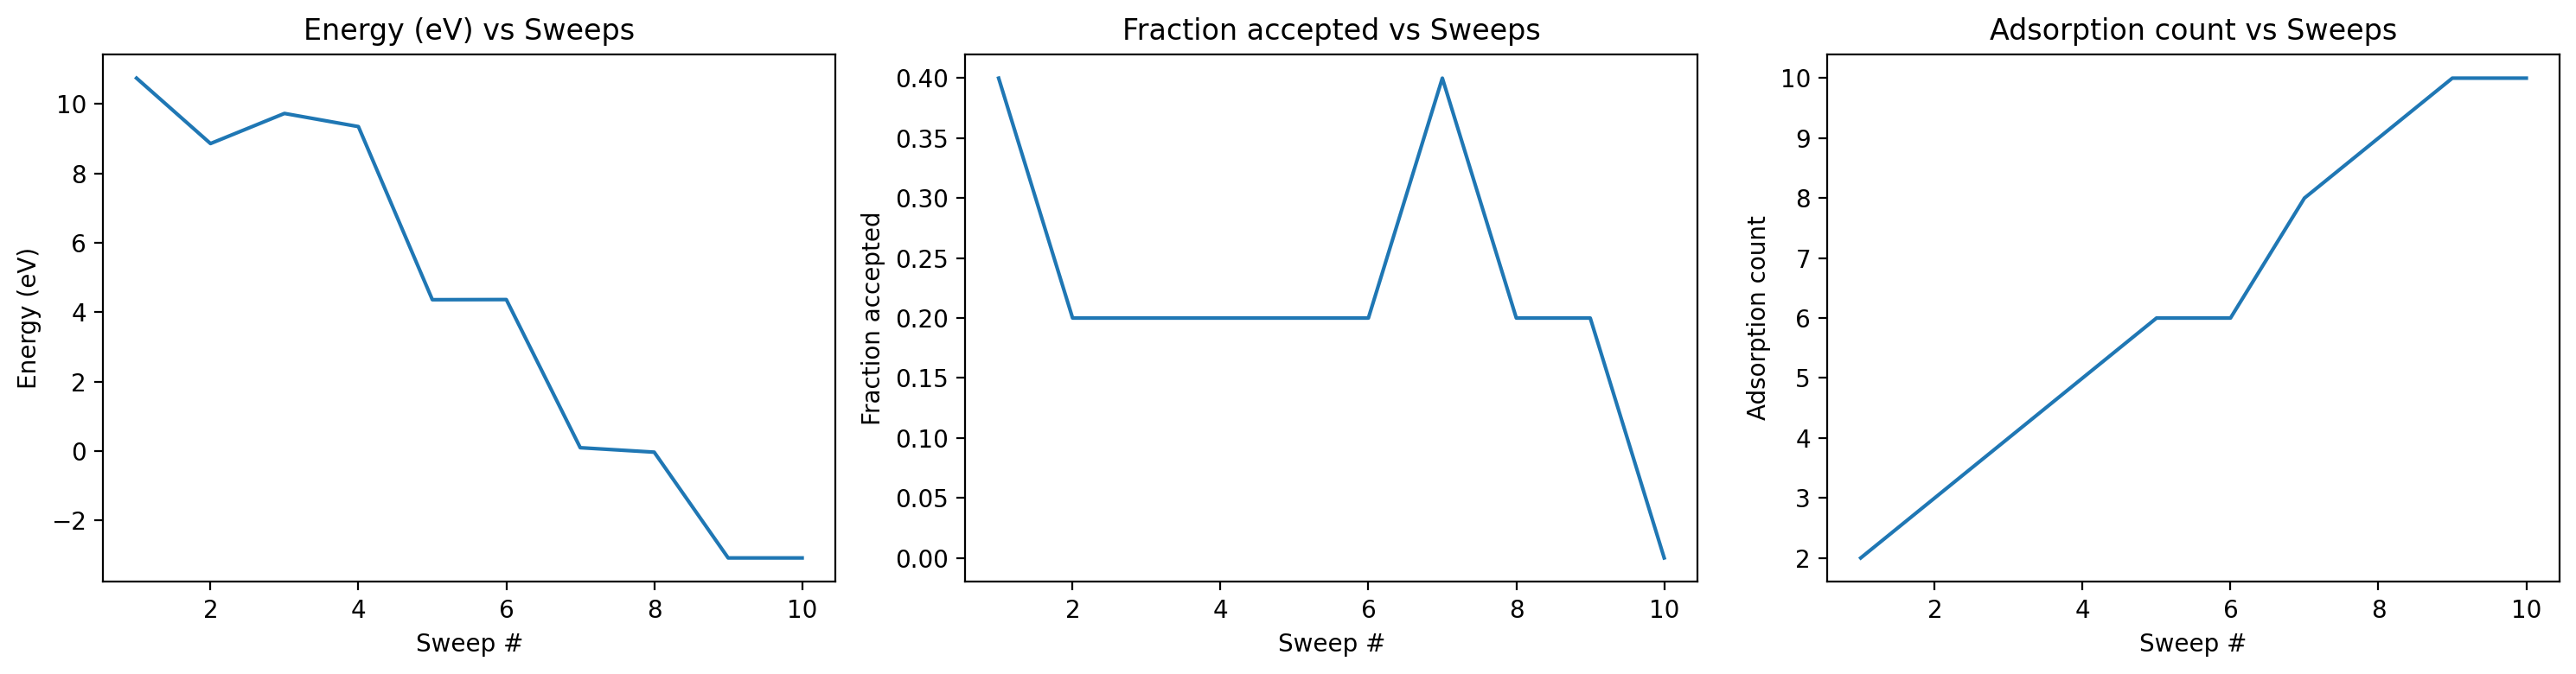

In [ ]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [ ]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)